/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total convolution layers: 49
conv_layers


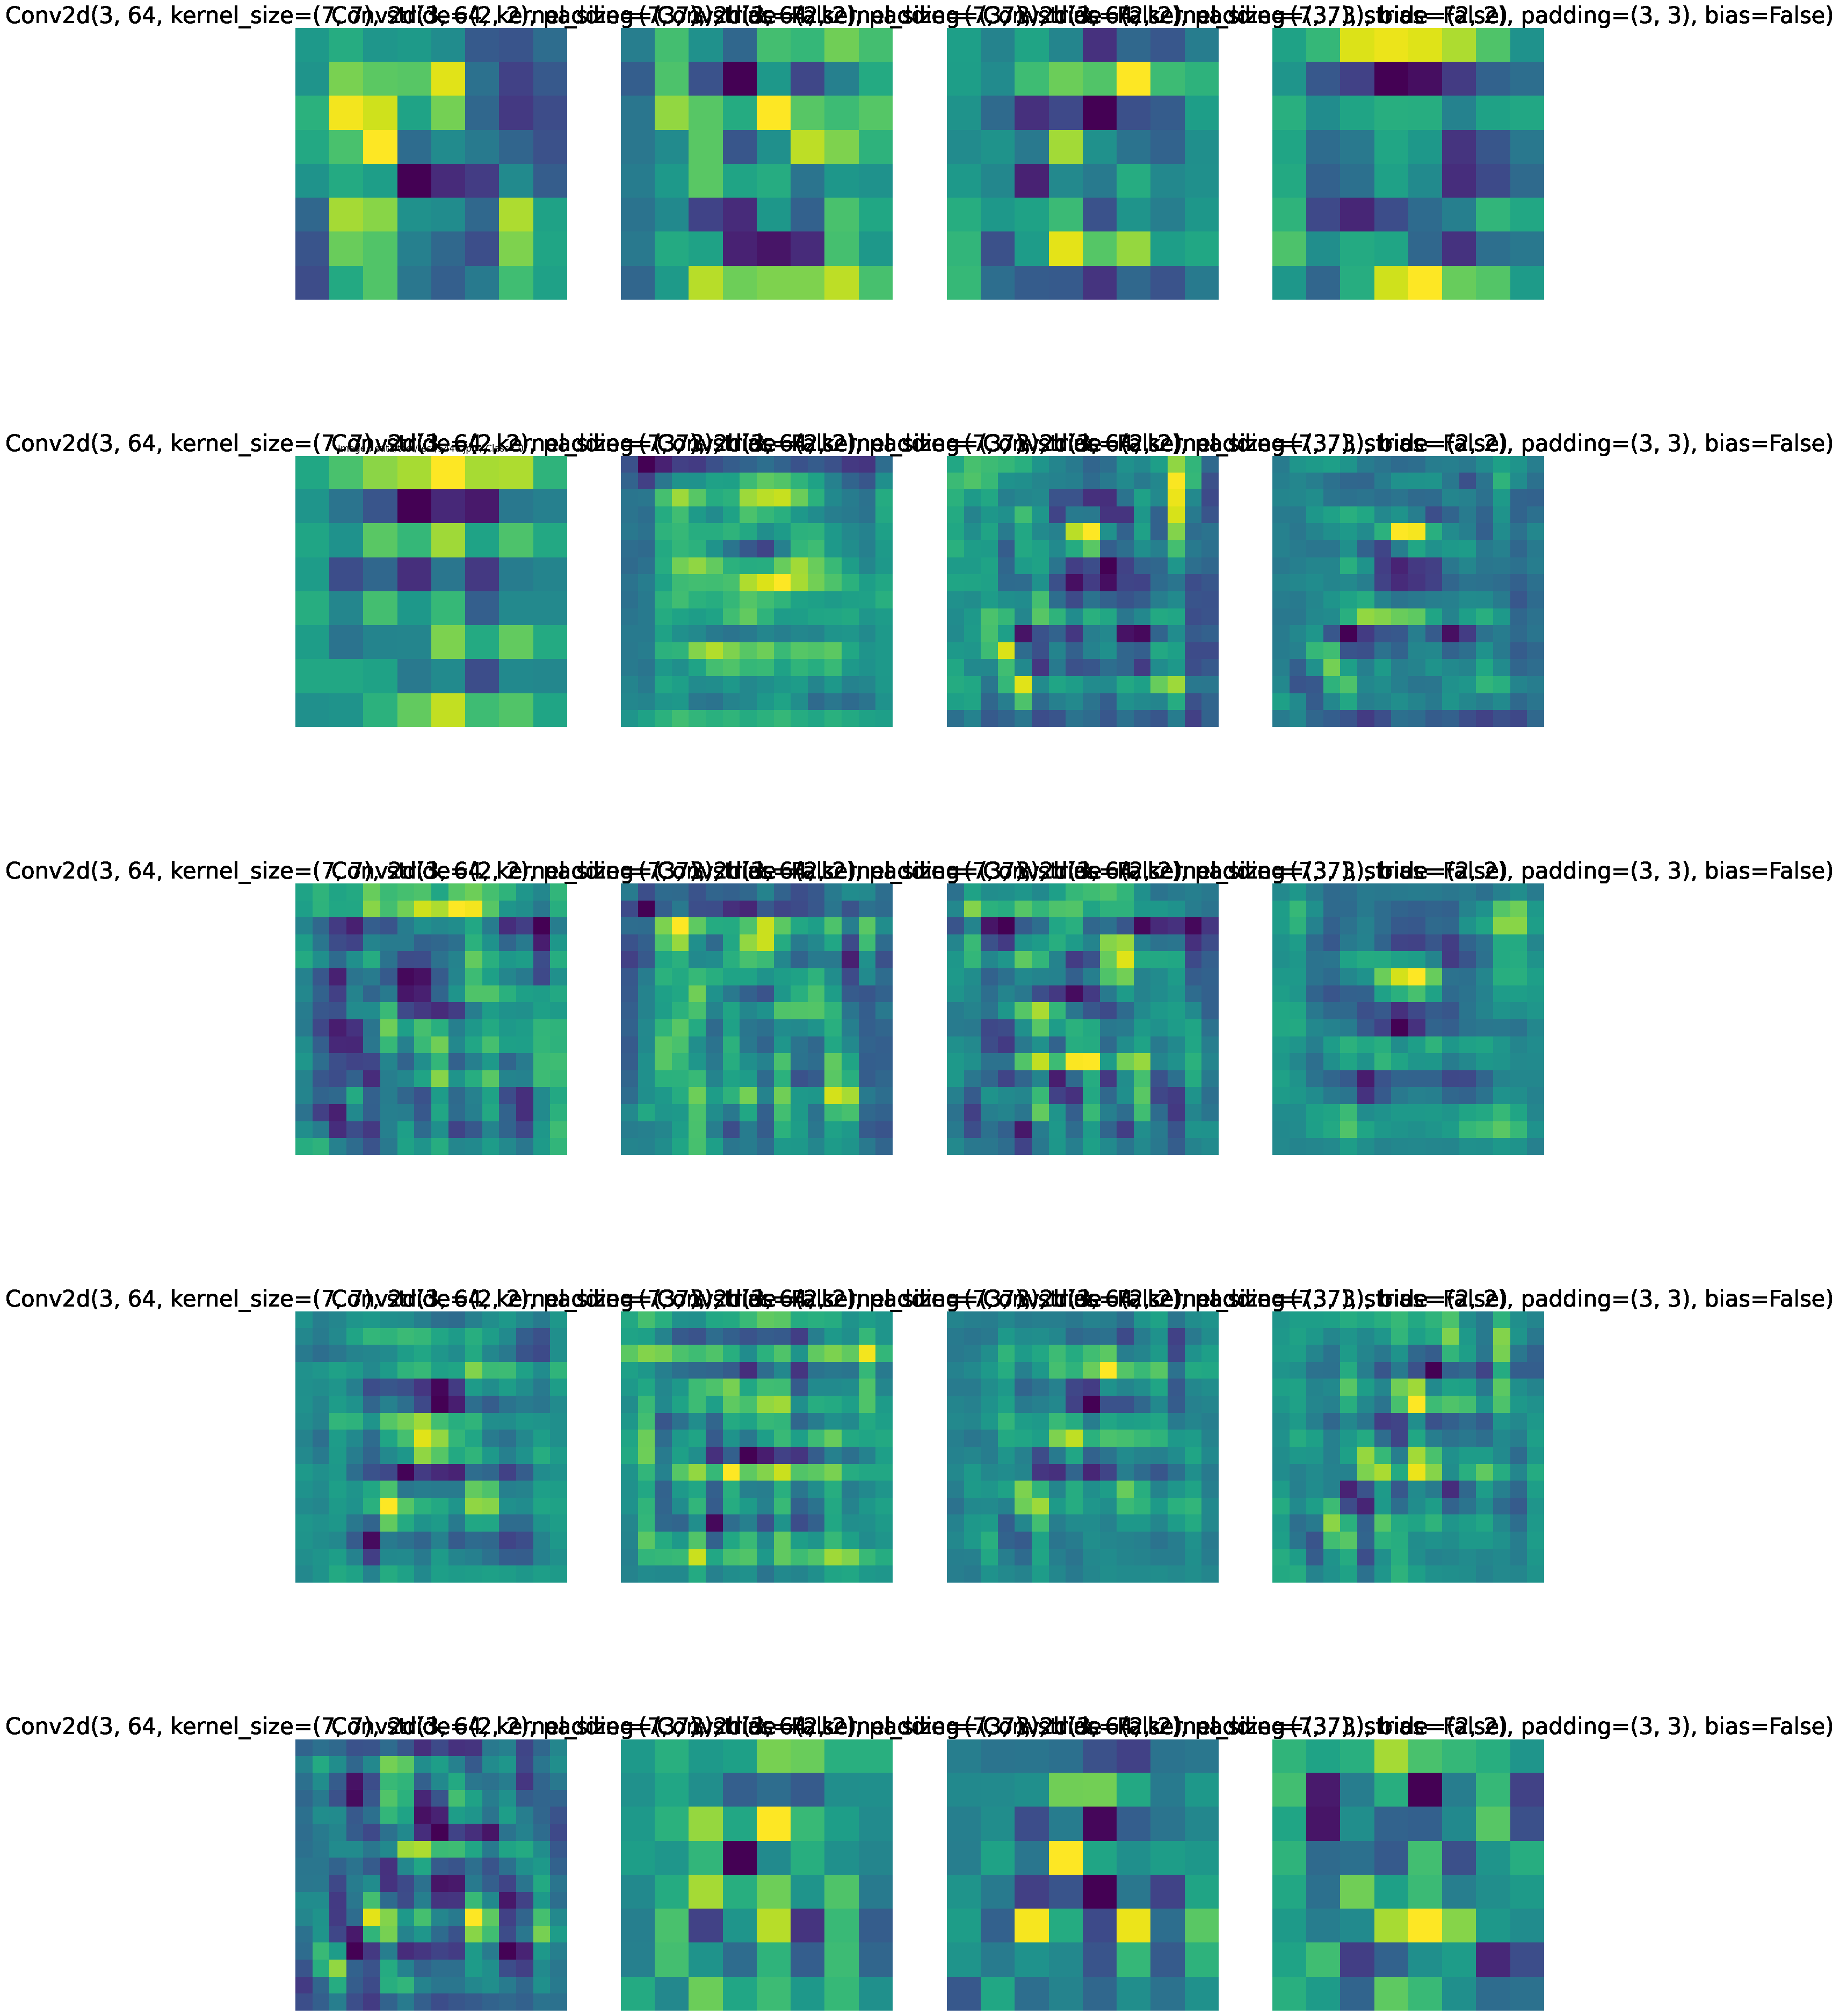

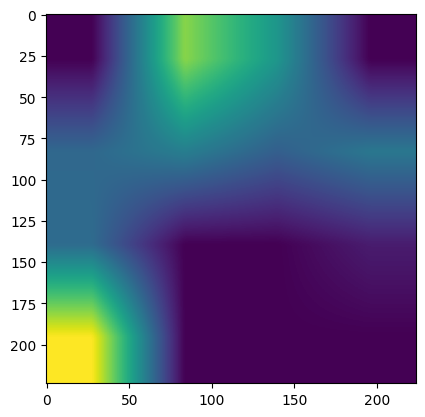

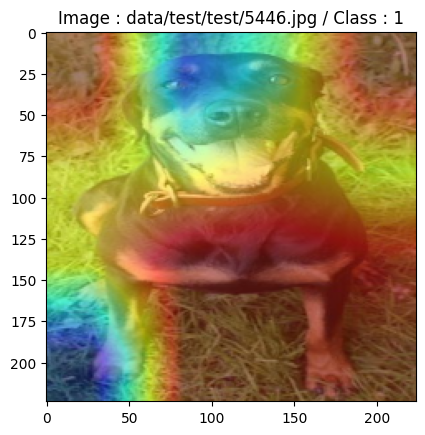

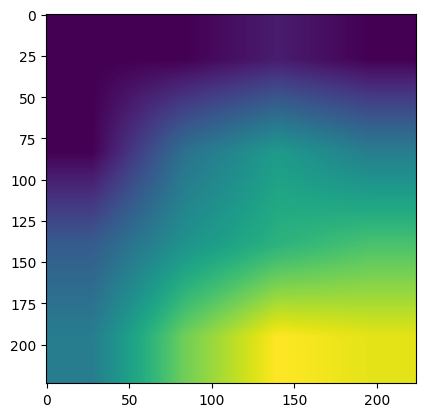

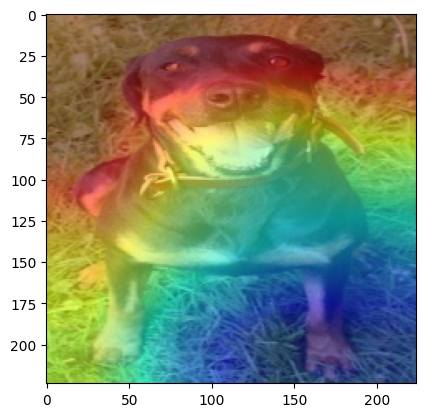

In [1]:
import numpy as np # linear algebra
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image

from src.gradcam import GradCam, eval_image, get_bdbox_from_heatmap
from src.data_loading import get_resnet_transforms
from src.model import ResNet
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_classes = 2
model = ResNet(nbr_classes=2)
tr = get_resnet_transforms()
# In ResNet 50, layer4 is the last module containing Conv boxes ( after that there is average pooling, fully connected .. )
# In this module the layer2 will get us the last conv layer

grad_cam = GradCam(model.model,  feature_layer=model.model.layer4, target_layer=['2'], device=device)

threshold = 0.2

# list images in folder
image_folder_path = 'data/test/test'
images = [os.path.join(image_folder_path, filename) for filename  in  os.listdir(image_folder_path)[1:20]]

for image in images:
    # Apply gradcam algorithm on the image
    # In the output of the fully connected layer, the fifth neuron ocrresponds ( after softmax ) to the probability of being an image of a dog
    #print("Image : ", image)
    input_img, grayscale_cam, cam, img = eval_image(grad_cam, image, target_category=0, transform_pipeline=tr)
    model.visualize_feature_maps(tr(Image.open(image)).to(device))
    # Extract all objects from heatmap
    objects = get_bdbox_from_heatmap(grayscale_cam, threshold=threshold)
    #  Loop in each one of the objects and adding it in the detection output
    for obj in objects[::-1]:
        xmin, xmax, ymin, ymax, width, height = obj
        bbox = np.r_[int(xmin), int(ymin), int(xmax), int(ymax)]
    # plot input img and grayscale cam and cam
    # change  input_img shapee from (1, 3, 128, 128) to (128, 128, 3)
    input_img = np.transpose(input_img.squeeze(), (1, 2, 0))
    
    # plt.figure()
    # plt.imshow(input_img)
    plt.title("Image : " + image+  " / Class : " + str(0))
    plt.figure()
    plt.imshow(grayscale_cam)
    plt.figure()
    plt.imshow(cam)
    
    input_img, grayscale_cam, cam, img = eval_image(grad_cam, image, target_category=1, transform_pipeline=tr)
    # Extract all objects from heatmap
    objects = get_bdbox_from_heatmap(grayscale_cam, threshold=threshold)
    #  Loop in each one of the objects and adding it in the detection output
    for obj in objects[::-1]:
        xmin, xmax, ymin, ymax, width, height = obj
        bbox = np.r_[int(xmin), int(ymin), int(xmax), int(ymax)]
    # plot input img and grayscale cam and cam
    # change  input_img shapee from (1, 3, 128, 128) to (128, 128, 3)
    input_img = np.transpose(input_img.squeeze(), (1, 2, 0))
    
    # plt.figure()
    # plt.imshow(input_img)
    plt.title("Image : " + image+  " / Class : " + str(1))
    plt.figure()
    plt.imshow(grayscale_cam)
    plt.figure()
    plt.imshow(cam)
    break
plt.show()

data/test/test/5446.jpg
input_tensor : torch.Size([1, 3, 128, 128])
[[[ 97 120 142]
  [102 125 147]
  [ 97 120 143]
  ...
  [ 53  89 112]
  [ 56  92 114]
  [ 48  84 107]]

 [[ 93 121 139]
  [ 83 112 131]
  [ 89 117 139]
  ...
  [ 57  91 115]
  [ 47  81 105]
  [ 56  90 114]]

 [[ 82 114 131]
  [ 78 109 128]
  [ 78 109 131]
  ...
  [ 39  70  99]
  [ 50  80 109]
  [ 58  88 118]]

 ...

 [[113  76  34]
  [105  67  26]
  [ 99  61  21]
  ...
  [ 39  68  97]
  [ 32  61  90]
  [ 52  81 111]]

 [[101  68  20]
  [109  75  29]
  [ 99  63  20]
  ...
  [ 57  84 113]
  [ 41  68  98]
  [ 43  70 101]]

 [[106  73  28]
  [103  68  25]
  [103  67  25]
  ...
  [ 39  66  97]
  [ 47  76 106]
  [ 47  75 105]]]


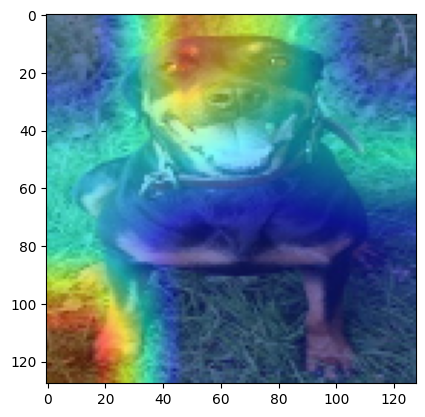

In [17]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2
from src.gradcam import preprocess_image

print(model)

target_layers = [model.model.layer4[2]]
path = images[0]
print(images[0])

img = cv2.imread(path, 1)
#img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
# Opencv loads as BGR:
# print("img shape : ", img.shape)
img = cv2.resize(img[:, :, ::-1], (128, 128))
input_tensor = preprocess_image(img, tr)
# read imagee with oopencv and convert it to rgb
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:

cam = GradCAM(model=model.model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
print(f"input_tensor : {input_tensor.shape}")
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
print(visualization)
import matplotlib.pyplot as plt
plt.imshow(visualization)

plt.show()